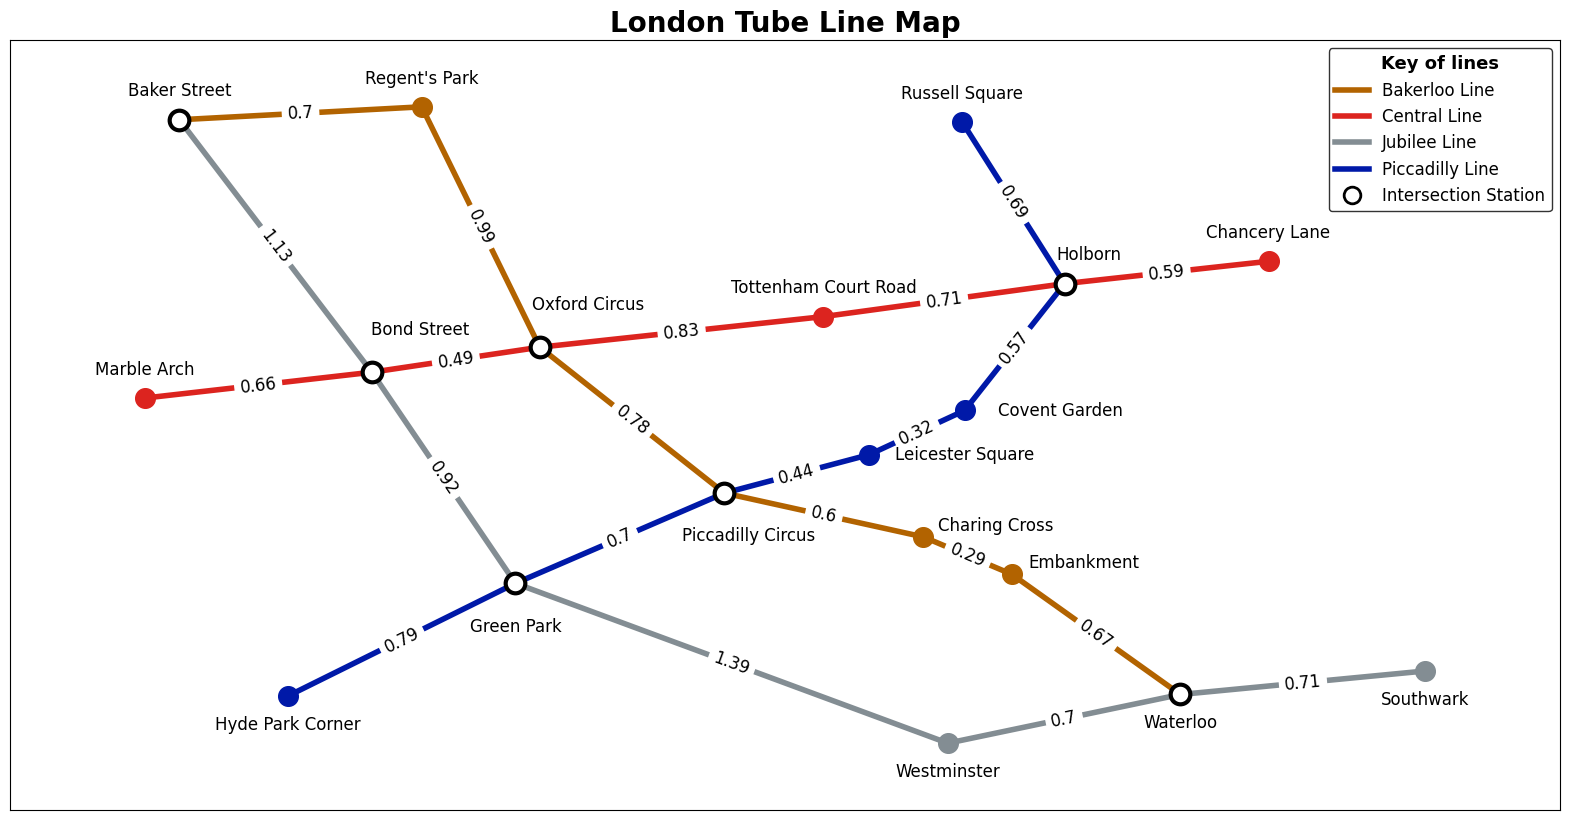

Total length of the transport network: 15.67 km
Average distance between stations: 0.71 km
Standard deviation of distances between stations: 0.25 km


In [23]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ------------------- Data Loading -------------------
# Load the CSV file
file_path = 'London stations.csv'
stations_data = pd.read_csv(file_path)
stations_data.columns = stations_data.columns.str.strip()

# ------------------- Haversine Function -------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ------------------- Graph Data Preparation -------------------
bakerloo_line_edges = [
    ("Waterloo", "Embankment"),
    ("Embankment", "Charing Cross"),
    ("Charing Cross", "Piccadilly Circus"),
    ("Piccadilly Circus", "Oxford Circus"),
    ("Oxford Circus", "Regent's Park"),
    ("Regent's Park", "Baker Street")
]

central_line_edges = [
    ("Marble Arch", "Bond Street"),
    ("Bond Street", "Oxford Circus"),
    ("Oxford Circus", "Tottenham Court Road"),
    ("Tottenham Court Road", "Holborn"),
    ("Holborn", "Chancery Lane")
]

jubilee_line_edges = [
    ("Baker Street", "Bond Street"),
    ("Bond Street", "Green Park"),
    ("Green Park", "Westminster"),
    ("Westminster", "Waterloo"),
    ("Waterloo", "Southwark")
]

piccadilly_line_edges = [
    ("Hyde Park Corner", "Green Park"),
    ("Green Park", "Piccadilly Circus"),
    ("Piccadilly Circus", "Leicester Square"),
    ("Leicester Square", "Covent Garden"),
    ("Covent Garden", "Holborn"),
    ("Holborn", "Russell Square"),
]

edges = []
edge_labels = {}
color_mapping = {
    'bakerloo': '#B26300',
    'central': '#DC241F',
    'jubilee': '#838D93',
    'piccadilly': '#0019A8',
}

for edge_list, line_color in [
    (bakerloo_line_edges, color_mapping['bakerloo']),
    (central_line_edges, color_mapping['central']),
    (jubilee_line_edges, color_mapping['jubilee']),
    (piccadilly_line_edges, color_mapping['piccadilly']),
    ]:
    for edge in edge_list:
        station1 = stations_data[stations_data['Station'] == edge[0]].iloc[0]
        station2 = stations_data[stations_data['Station'] == edge[1]].iloc[0]
        distance = haversine(station1['Latitude'], station1['Longitude'],
                             station2['Latitude'], station2['Longitude'])
        edges.append((edge[0], edge[1], round(distance, 2), line_color))
        edge_labels[(edge[0], edge[1])] = f"{round(distance, 2)}"

G = nx.Graph()
for _, row in stations_data.iterrows():
    G.add_node(row['Station'], pos=(row['Longitude'], row['Latitude']))

for edge in edges:
    G.add_edge(edge[0], edge[1], color=edge[3], weight=edge[2])

stations_by_line = {
    'bakerloo': set(station for edge in bakerloo_line_edges for station in edge),
    'central': set(station for edge in central_line_edges for station in edge),
    'jubilee': set(station for edge in jubilee_line_edges for station in edge),
    'piccadilly': set(station for edge in piccadilly_line_edges for station in edge),
}

intersection_stations = set()
for station in G.nodes():
    line_count = sum(station in stations_by_line[line] for line in stations_by_line)
    if line_count >= 2:
        intersection_stations.add(station)

# Filter out nodes not in any line
node_colors = {}
for node in G.nodes():
    if node in intersection_stations:
        node_colors[node] = '#ffffff'
    elif node in stations_by_line['bakerloo']:
        node_colors[node] = color_mapping['bakerloo']
    elif node in stations_by_line['central']:
        node_colors[node] = color_mapping['central']
    elif node in stations_by_line['jubilee']:
        node_colors[node] = color_mapping['jubilee']
    elif node in stations_by_line['piccadilly']:
        node_colors[node] = color_mapping['piccadilly']

# Filter graph to only include relevant nodes
G_filtered = G.subgraph(node_colors.keys())

# Adjust labels based on initial positions
positions = nx.get_node_attributes(G_filtered, 'pos')
label_pos_adjustments = {
    "Baker Street": (positions["Baker Street"][0], positions["Baker Street"][1] + 0.001),
    "Bond Street": (positions["Bond Street"][0] + 0.002, positions["Bond Street"][1] + 0.0015),
    "Chancery Lane": (positions["Chancery Lane"][0], positions["Chancery Lane"][1] + 0.001),
    "Charing Cross": (positions["Charing Cross"][0] + 0.003, positions["Charing Cross"][1] + 0.0004),
    "Covent Garden": (positions["Covent Garden"][0] + 0.004, positions["Covent Garden"][1]),
    "Embankment": (positions["Embankment"][0] + 0.003, positions["Embankment"][1] + 0.0004),
    "Green Park": (positions["Green Park"][0], positions["Green Park"][1] - 0.0015),
    "Holborn": (positions["Holborn"][0] + 0.001, positions["Holborn"][1] + 0.001),
    "Hyde Park Corner": (positions["Hyde Park Corner"][0], positions["Hyde Park Corner"][1] - 0.001),
    "Leicester Square": (positions["Leicester Square"][0] + 0.004, positions["Leicester Square"][1]),
    "Marble Arch": (positions["Marble Arch"][0], positions["Marble Arch"][1] + 0.001),
    "Oxford Circus": (positions["Oxford Circus"][0] + 0.002, positions["Oxford Circus"][1] + 0.0015),
    "Piccadilly Circus": (positions["Piccadilly Circus"][0] + 0.001, positions["Piccadilly Circus"][1] - 0.0015),
    "Regent's Park": (positions["Regent's Park"][0], positions["Regent's Park"][1] + 0.001),
    "Russell Square": (positions["Russell Square"][0], positions["Russell Square"][1] + 0.001),
    "Tottenham Court Road": (positions["Tottenham Court Road"][0], positions["Tottenham Court Road"][1] + 0.001),
    "Southwark": (positions["Southwark"][0], positions["Southwark"][1] - 0.001),
    "Waterloo": (positions["Waterloo"][0], positions["Waterloo"][1] - 0.001),
    "Westminster": (positions["Westminster"][0], positions["Westminster"][1] - 0.001),
}

# ------------------- Graph Visualization -------------------
plt.figure(figsize=(20, 10))

# Draw non-intersection nodes
for node in G_filtered.nodes():
    if node not in intersection_stations:
        nx.draw_networkx_nodes(
            G_filtered,
            pos=positions,
            nodelist=[node],
            node_size=200,
            node_color=node_colors[node]
        )

# Draw intersection nodes
for node in intersection_stations:
    x, y = positions[node]
    plt.scatter(x, y, s=200, color='#ffffff', edgecolor='#000000', linewidth=3, zorder=3)

# Draw edges with colors
edge_colors = [G_filtered[u][v]['color'] for u, v in G_filtered.edges()]
nx.draw_networkx_edges(
    G_filtered,
    pos=positions,
    edge_color=edge_colors,
    width=4
)

# Draw labels with adjusted positions
nx.draw_networkx_labels(
    G_filtered,
    pos=label_pos_adjustments,  # Use adjusted positions for labels
    font_size=12,
    font_weight='normal'
)

# Draw labels for edges (distances in km)
nx.draw_networkx_edge_labels(
    G_filtered,
    pos=positions,
    edge_labels=edge_labels,
    font_size=12,
    font_weight='normal'
)

# Add legend with title "Key"
legend_elements = [
    plt.Line2D([0], [0], color=color_mapping['bakerloo'], lw=4, label='Bakerloo Line'),
    plt.Line2D([0], [0], color=color_mapping['central'], lw=4, label='Central Line'),
    plt.Line2D([0], [0], color=color_mapping['jubilee'], lw=4, label='Jubilee Line'),
    plt.Line2D([0], [0], color=color_mapping['piccadilly'], lw=4, label='Piccadilly Line'),
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='#ffffff', 
               markeredgecolor='#000000', markersize=12, markeredgewidth=2, label='Intersection Station')
]

legend = plt.legend(handles=legend_elements, loc='upper right', fontsize=12, frameon=True, ncol=1, title="Key of lines")
legend.get_frame().set_edgecolor('#000000')  # Black border for the legend box
legend.get_frame().set_linewidth(1)        # Adjust border thickness
legend.get_title().set_fontsize('13')        # Font size for "Key" title
legend.get_title().set_fontweight('bold')    # Make "Key" title bold

# Add the main title for the visualization
plt.title("London Tube Line Map", fontsize=20, fontweight='bold')

# Show the plot
plt.show()
# ------------------- Distance Statistics -------------------
edges_data = pd.DataFrame(edges, columns=['Station1', 'Station2', 'Distance', 'LineColor'])

total_length = round(edges_data['Distance'].sum(), 2)
average_distance = round(edges_data['Distance'].mean(), 2)
std_distance = round(edges_data['Distance'].std(), 2)

print("Total length of the transport network:", total_length, "km")
print("Average distance between stations:", average_distance, "km")
print("Standard deviation of distances between stations:", std_distance, "km")
